# Sea Ice Demonstration Project

This project is to demonstrate a variety of machine learning techniques using real synthetic aperture radar (SAR) images.

The data (from https://zenodo.org/record/4683174#.YKKKD6hKhPZ) is from the Sentinel-1 satelites and covers a portion of coast and ocean off Danmarkshavn on the east coast of Greenland. Data was taken in HH and HV polarizations once a month for the year of 2018. Some preprocessing has been done already, so I'll be starting with despeckled and terrain-corrected geolocated images. The RGB values correspond to the scaled HV/HH (cross/co-polarisation ratio), HV, and HH values.

The data has been classified by an expert on sea ice and use of SAR data for its identification, so I will take these labels as the truth. My goal will be to produce a model that can correctly identify the presence or concentration of sea ice at a given location within an image. I will measure how well the model can reproduce the labels on observations with which it is trained, as well as new observations which it has not seen before. I will test a variety of model types, including gaussian naive bayes, decision tree, random forest, support vector machine, neural net, and convolutional neural net. I will also use unsupervised learning techniques (KMeans, gaussian mixture model) to gain insight on how well I should expect my models to be able to do with the given dataset.

### Outline of the project:
    Load the data and examine a sample image
    First set of models: fitting a single image
        Process a sample image to extract the pixels with actual data 
        Split data into training, testing sets
        Train and evaluate a simple Gaussian Naive Bayes
            check accuracy score by examining confusion matrix
        Resample the data to obtain even sampling across classes
        Reevaluate the GNB model
        Build a decision tree model
            evaluate success of the model
            examine the structure of the first few layers
            check for overfitting with cross-validation
        Build and evaluate a random forest
    Second set of models: fitting the entire set of training observations
        Process the entire dataset
            extract the meaninful pixels
            add information about the surrounding pixels to the model input
            separate training, testing, and validation observations
        Split data from training observations into training, testing, and validation sets
        Examine the data distibution and correlations of features
        Train three candidate models and evaluate and evaluate on the test observation 
            SVM
            random forest
            neural net
    Unsupervised learning: determining how many categories my models really should be able to detect
        KMeans clustering
            examining the inertia and silhouette score to determine the optimal number of clusters
            Gaussian Mixture Modelling:
        calculating BIC and AIC for various numbers clusters
    Third set of models: using image recognition models for classification
        Re-process the data to extract 13x13 pixel sub-images
        Train and evaluate two candidate models:
            convolutional neural net
            random forest
    Select the final model and test on the validation dataset and validation observation
    
###  Results:
While the more advanced models (random forests, nueral nets) all achieve relatively high accuracy on the observations with which they were trained, they perform relatively poorly on the test observation (with which they weren't trained). This indicates that they are overfitting the systematics of the training observations, which do not generalize well to new observations. However, the models do seem to be good at discriminating within the categoires of ice, open-water, and land. The selected final model (random forest using the 13x13 sub-images) achieves an accuracy of 92% on the validation dataset, and 95% on the validation observation. 

Future steps to improve the model would be first and foremost to aquire more observations, so that the model can better learn to ignore systematics within each observation. Secondly would be to do some more pre-processing to remove the systematics before the model is fit. Additionally, the model could be trained to output the stage information (essentially how old the ice is), but the images for the stage labels need additional preprocessing. 

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd
import seaborn as sns
#plt.rcParams['figure.figsize'] = [6, 6]
#%matplotlib widget
%matplotlib inline
from PIL import Image
from tensorflow import keras
import warnings
from scipy import stats

In [2]:
# Load the satelite images as well as the targets: the ice concentrations and types ('stage')
# There is a separate folder for each month's data
rgb = {}
conc = {}
stage = {}
for i in range(1,13):
    rgb[i] = np.asarray(Image.open(str(i)+'/rgb.png'))[:,:,:3] # don't need the transparency value of the png
    stage[i] = np.asarray(Image.open(str(i)+'/stage.png'))[:,:,:3]
    conc[i] = np.asarray(Image.open(str(i)+'/conc.png'))[:,:,:3]

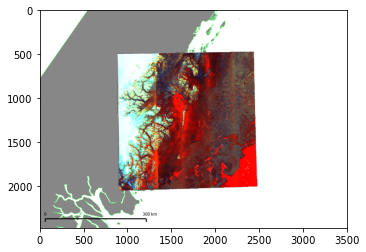

In [140]:
# First I'll examine an example image and its corresponding labels
plt.figure()
plt.imshow(rgb[6])

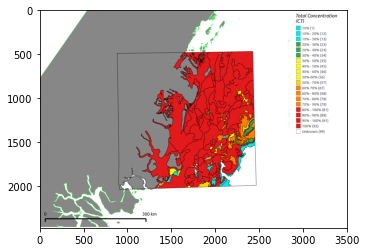

In [141]:
plt.figure()
plt.imshow(conc[6])

The labels indicate the ice concentration. In this image, most of the ice is at 100% concentration, but there are representative areas for each of the concentration categories, indicated by the colors.

Next, I'll gather the image data into a dataframe, just keeping the rgb values of the pixels. Later I will add information about the nearby pixels as well. 

In [6]:
# indices keeps track of the x and y pixel numbers
indices = np.moveaxis(np.indices(rgb[6].shape)[0:2,:,:,0], 0, 2)
allArray = np.dstack((indices, rgb[6])).reshape((-1, 5))
targetarray = np.dstack((indices, conc[6])).reshape((-1, 5))

data = pd.DataFrame(allArray, columns=['y', 'x', 'red','green','blue'])
targetDF = pd.DataFrame(targetarray, columns=['y', 'x', 'red','green','blue'])

In [7]:
print(data.shape)
print(targetDF.shape)

(8697360, 5)
(8697360, 5)


Next I will match the colors in the target image to the colors used to indicate different levels of ice concentration.

I'll also want to exclude colors in the data image that do not correspond to real data.

In [8]:
forbiddencolors = np.array(((135,135,135),(79,255,99),(255,255,255),(0,0,0)))
colorlabels = ['cyan','green','yellow','offyellow','orange','red','white','gray']
colors = np.array(((0,233,233),(57,163,73),(255,251,7),(252,215,0),(255,128,1),(227,26,28),(255,255,255),(135,135,135)))

In [9]:
datamatch = pd.Series(np.ones(len(data), dtype=bool))
targetcolormatch = pd.Series(np.zeros(len(data), dtype=bool))
# Exclude colors in the data image that are known to not correspond to real data 
for i in range(0,len(forbiddencolors)):
    datamatch = datamatch&(~((data.loc[:,'red'] == forbiddencolors[i,0]) & (data.loc[:,'green'] == forbiddencolors[i,1]) & (data.loc[:,'blue'] == forbiddencolors[i,2])))
# Only use data where the color actually matches one of the colors in the ice concentration legend
for i in range(0,len(colors)):
    targetcolormatch = targetcolormatch|((targetDF.loc[:,'red'] == colors[i,0]) & (targetDF.loc[:,'green'] == colors[i,1]) & (targetDF.loc[:,'blue'] == colors[i,2]))

fullmatch = datamatch & targetcolormatch
cleandata = data.loc[fullmatch,:]
cleantargets = targetDF.loc[fullmatch,:]

In [10]:
print(cleandata.shape)
print(cleantargets.shape)

(2159549, 5)
(2159549, 5)


To check that the processing worked, I'll plot the same image with only data that meets the above conditions shown

In [11]:
#repopulate the picture with only the data shown
newpic = np.zeros(rgb[1].shape)
newpic[cleandata.y,cleandata.x,0] = cleandata.red
newpic[cleandata.y,cleandata.x,1] = cleandata.green
newpic[cleandata.y,cleandata.x,2] = cleandata.blue

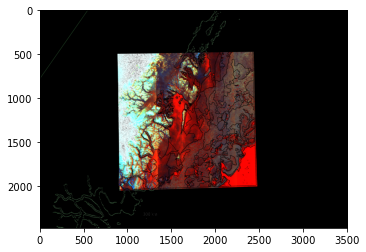

In [12]:
plt.figure()
plt.imshow(newpic.astype(int))

The data is mostly intact. Note the lines designating the boundaries in the target image caused data to be removed there.

Next I'll map the colors onto the labels (0,1,2,4,5,6,7). 

The labels are 'cyan', 'green', 'yellow', 'offyellow', 'orange', 'red', 'white', 'gray'

These correspond to 'not much ice' (0) ... '100% ice' (5), 'open ocean' (6) and 'land' (7)

In [13]:
target = pd.DataFrame({'y':cleantargets.y,'x':cleantargets.x,'target':np.zeros(len(cleandata))})
for i in range(0,len(colors)):
    target.loc[(cleantargets.loc[:,'red'] == colors[i,0]) & (cleantargets.loc[:,'green'] == colors[i,1]) & (cleantargets.loc[:,'blue'] == colors[i,2]),'target'] = i

In [14]:
target.target.unique()

array([7., 6., 5., 2., 3., 1., 4., 0.])

Now I'll split the data from this single observation into training, testing, and validation sets. Since I'll later use more observations, I won't end up using the validation set.

In [15]:
x_train_all, x_validate, y_train_all, y_validate = model_selection.train_test_split(cleandata.loc[:,'red':'blue'], target.target, test_size=0.1)

# now split the training data further into training and testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train_all, y_train_all, test_size=0.2)

Train and evaluate a Gaussian Naive Bayes model. This has the advantage of training very quickly.

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
modelGNB = gnb.fit(x_train, y_train)
y_pred = modelGNB.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.7452092642757364


Not too bad for eight different categories! However, let's look at its confusion matrix to see if is really getting things right.

Text(0.5, 15.0, 'predicted label')

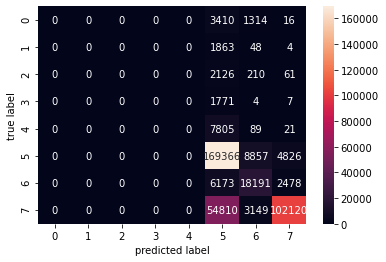

In [17]:
plt.figure()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Ok now I see that it is actually terrible at identifying anything less than 100% ice (label 5). I should train it on a balanced dataset if I don't want to make any asumptions about how the input data is distributed.

Let's check the distribution of the data:

In [18]:
target.target.value_counts()

5.0    1015395
7.0     892624
6.0     148025
4.0      43952
0.0      25780
2.0      13341
1.0      10349
3.0      10083
Name: target, dtype: int64

Every class has a decent number of insances, so we can just resample the data so that all the classes have the same number of representatives.

In [19]:
# resample the data to rebalance the classes
nsamp = np.min(target.target.value_counts())
dataresampledmat = np.zeros((nsamp,5,len(target.target.unique())))
targetresampledmat = np.zeros((nsamp,3,len(target.target.unique())))
# resample each class separately 
for targ in target.target.unique():
    dataresampledmat[:,:,int(targ)], targetresampledmat[:,:,int(targ)] = resample(cleandata.loc[target.target == targ,:],target.loc[target.target == targ,:],n_samples = nsamp)

# recombine the resampled data
dataresampled = pd.DataFrame(np.hstack(dataresampledmat.transpose()).transpose(), columns=['y', 'x', 'red', 'green', 'blue'])
targetresampled = pd.DataFrame(np.hstack(targetresampledmat.transpose()).transpose(), columns=['y', 'x', 'target'])

Check that the resampling worked, and then split into training, testing, validation:

In [20]:
targetresampled.target.value_counts()

0.0    10083
4.0    10083
3.0    10083
1.0    10083
7.0    10083
2.0    10083
5.0    10083
6.0    10083
Name: target, dtype: int64

In [21]:
x_train_all, x_validate, y_train_all, y_validate = model_selection.train_test_split(dataresampled.loc[:,'red':'blue'], targetresampled.target, test_size=0.1)
# now split the training data further into training and testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train_all, y_train_all, test_size=0.2)

Run the Gaussian Naive Bayes model again and check the accuracy and confusion matrix:

In [22]:
gnb = GaussianNB()
modelGNB = gnb.fit(x_train, y_train)
y_pred = modelGNB.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.3059228650137741


Text(0.5, 15.0, 'predicted label')

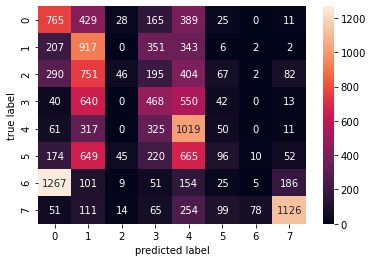

In [23]:
plt.figure()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Okay now the naive model looks a lot worse. It did okay identifying land, and the error it made on the open water (putting it all in the lowest ice category) is not unforgivable maybe. But it can't discriminate any of the concentrations of ice from each other.

Let's try building a decision tree

In [24]:
#Decision tree
from sklearn import tree
clfTree = tree.DecisionTreeClassifier()
model = clfTree.fit(x_train,y_train)
clfTree.get_depth()

40

I intentionally let the decision tree build as deep as it wanted, and doing so should mean it completely overfit the data. First I'll take a look at the structure of the tree produced, and then I'll check the accuracy and the cross validation performance.

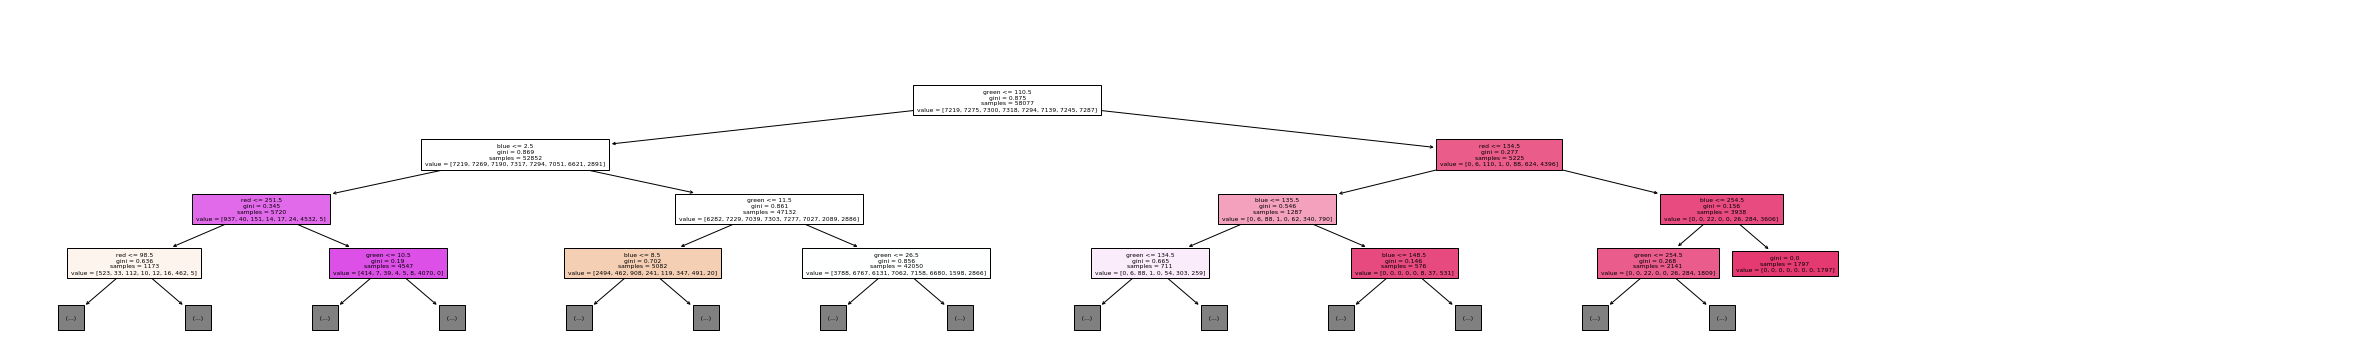

In [25]:
# visualize the tree that was created
plt.figure(figsize=(33,5))
tree.plot_tree(model,max_depth=3,filled=True,fontsize=6,feature_names=['red','green','blue'])
plt.tight_layout()

In [26]:
y_pred = model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.572038567493113


In [27]:
# check the cross validation performance to better understand the overfitting
scores = model_selection.cross_val_score(clfTree, x_train, y_train, cv=10)
print(scores.mean(),',',scores.std())

0.564268141280994 , 0.004579485004790891


Okay now let's try a Random Forest to see if it can do better than a single tree

In [28]:
from sklearn.ensemble import RandomForestClassifier
RFclf = RandomForestClassifier(max_depth=20,n_estimators=1000)
modelRF=RFclf.fit(x_train,y_train)

In [29]:
y_pred = modelRF.predict(x_test)

In [30]:
score = accuracy_score(y_test, y_pred)
print(score)

0.5804407713498623


Text(0.5, 15.0, 'predicted label')

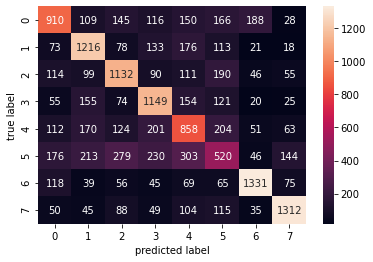

In [31]:
plt.figure()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

The random forest seems a lot better than the naive bayes approach, but before I can say how generalizable the model is, I should add in the rest of the data and test the model on an observation that is separate from the training data.

I also want to give the model more information about the neighboring pixels. Looking at the image above, one of the things that seems to change for the different categories is how variegated the color is. So I'll try adding the mean and standard deviation of the surrounding pixels (two pixels away in either direction).

In [135]:
# Combine all training observations, test observation, and process validation observation
# Randomly choose an observation for testing and one for validation
# I'm excluding observations 3, 7, and 11 because they would require additional preprocessing
trainingN = [1,2,5,6,8,9,10]
testingN = [4]
valN = [12]
obs = trainingN.copy()
obs.extend(testingN)
obs.extend(valN)
# Initialize combined datasets 
cleandata_train_all = pd.DataFrame()
target_train_all = pd.DataFrame()
cleandata_test_all = pd.DataFrame()
target_test_all = pd.DataFrame()
cleandata_val_all = pd.DataFrame()
target_val_all = pd.DataFrame()
# Ignore these warnings, as the code takes a lot of nanmean's of slices with all nans
warnings.filterwarnings("ignore", message='Degrees of freedom <= 0 for slice.')
warnings.filterwarnings("ignore", message='Mean of empty slice')
for j in obs:
    print('Processing Image '+str(j))
    # Set forbidden colors to nan
    data_nans=rgb[j].copy().astype(float)
    for i in range(0,len(forbiddencolors)):
        colormat = np.zeros(rgb[j].shape)
        colormat[:,:,:] = forbiddencolors[i,:]
        data_nans[np.sum(np.abs(colormat-rgb[j]),axis=2) == 0,:] = np.nan
    # Calculate nearby mean and std for each pixel
    testmat = np.zeros((rgb[j].shape[0],rgb[j].shape[1],3,25))
    pixel = 0
    for x in range(-2,3):
        for y in range(-2,3):
            mat = np.roll(data_nans[:,:,0],x,axis=1)
            testmat[:,:,0,pixel] = np.roll(mat,y,axis=0)
            mat = np.roll(data_nans[:,:,1],x,axis=1)
            testmat[:,:,1,pixel] = np.roll(mat,y,axis=0)
            mat = np.roll(data_nans[:,:,2],x,axis=1)
            testmat[:,:,2,pixel] = np.roll(mat,y,axis=0)
            pixel += 1
    stdpic=np.nanstd(testmat,axis=3)
    meanpic=np.nanmean(testmat,axis=3)
    # Save a copy of the std image for the example observation, for plotting later
    if j==6:
        stdpicsave=stdpic.copy()
    
    # Arrange the data and x, y, and observation info into a dataframe
    indices = np.moveaxis(np.indices(rgb[j].shape)[0:2,:,:,0], 0, 2)
    obsmat = j*np.ones(rgb[j].shape[:2])
    allArray = np.dstack((indices, obsmat, rgb[j], meanpic, stdpic)).reshape((-1, 12))
    targetarray = np.dstack((indices, obsmat, conc[j])).reshape((-1, 6))
    data = pd.DataFrame(allArray, columns=['y', 'x', 'obs','red','green','blue','meanR','meanG','meanB','stdR','stdG','stdB'])
    targetDF = pd.DataFrame(targetarray, columns=['y', 'x','obs', 'red','green','blue'])

    # Exclude data where the color is forbidden or where the target color does not match one of those in the legend
    datamatch = pd.Series(np.ones(len(data), dtype=bool))
    targetcolormatch = pd.Series(np.zeros(len(data), dtype=bool))
    for i in range(0,len(forbiddencolors)):
        datamatch = datamatch&(~((data.loc[:,'red'] == forbiddencolors[i,0]) & (data.loc[:,'green'] == forbiddencolors[i,1]) & (data.loc[:,'blue'] == forbiddencolors[i,2])))
    for i in range(0,len(colors)):
        targetcolormatch = targetcolormatch|((targetDF.loc[:,'red'] == colors[i,0]) & (targetDF.loc[:,'green'] == colors[i,1]) & (targetDF.loc[:,'blue'] == colors[i,2]))
    fullmatch = datamatch & targetcolormatch
    cleandata = data.loc[fullmatch,:]
    cleantargets = targetDF.loc[fullmatch,:]

    # Map the target colors onto their index in (0, ..., 7)
    target = pd.DataFrame({'y':cleandata.y,'x':cleandata.x,'obs':cleandata.obs,'target':np.zeros(len(cleandata))})
    for i in range(0,len(colors)):
        target.loc[(cleantargets.loc[:,'red'] == colors[i,0]) & (cleantargets.loc[:,'green'] == colors[i,1]) & (cleantargets.loc[:,'blue'] == colors[i,2]),'target'] = i
    
    # Add the data to the appropriate set
    if j in trainingN:
        cleandata_train_all = cleandata_train_all.append(cleandata)
        target_train_all = target_train_all.append(target)
    elif j in testingN:
        cleandata_test_all = cleandata_test_all.append(cleandata)
        target_test_all = target_test_all.append(target)
    elif j in valN:
        cleandata_val_all = cleandata_val_all.append(cleandata)
        target_val_all = target_val_all.append(target)
print('Done!')

Processing Image 1
Processing Image 2
Processing Image 5
Processing Image 6
Processing Image 8
Processing Image 9
Processing Image 10
Processing Image 4
Processing Image 12


Let's take a look at some of of the data. We can also check to make sure the x and y of the data and the target match up

In [35]:
cleandata_train_all.head(10)

,y,x,obs,red,green,blue,meanR,meanG,meanB,stdR,stdG,stdB
1066,0.0,1066.0,1.0,127.0,153.0,130.0,115.000000,178.333333,122.333333,8.640988,18.208667,5.557777
1067,0.0,1067.0,1.0,111.0,187.0,120.0,116.750000,174.500000,123.250000,8.073878,17.109939,5.068284
1068,0.0,1068.0,1.0,107.0,195.0,117.0,118.500000,170.500000,124.333333,9.878428,21.891779,6.182412
1069,0.0,1069.0,1.0,122.0,163.0,126.0,114.500000,178.666667,121.833333,10.468206,22.954060,6.413960
1070,0.0,1070.0,1.0,134.0,135.0,134.0,115.200000,177.000000,122.200000,11.338430,24.811288,6.968501
1076,0.0,1076.0,1.0,131.0,255.0,145.0,189.857143,255.000000,197.285714,64.009884,0.000000,56.731735
1080,0.0,1080.0,1.0,159.0,255.0,170.0,217.000000,255.000000,221.333333,41.529106,0.000000,36.745370
1081,0.0,1081.0,1.0,238.0,255.0,240.0,198.500000,255.000000,205.000000,39.500000,0.000000,35.000000
3503,0.0,3503.0,1.0,212.0,255.0,216.0,202.333333,255.000000,208.333333,28.986587,0.000000,25.486380
4584,1.0,1077.0,1.0,244.0,255.0,245.0,220.500000,255.000000,224.333333,46.053411,0.000000,40.921334


In [36]:
target_train_all.head(10)

,y,x,obs,target
1066,0.0,1066.0,1.0,7.0
1067,0.0,1067.0,1.0,7.0
1068,0.0,1068.0,1.0,7.0
1069,0.0,1069.0,1.0,7.0
1070,0.0,1070.0,1.0,7.0
1076,0.0,1076.0,1.0,6.0
1080,0.0,1080.0,1.0,6.0
1081,0.0,1081.0,1.0,6.0
3503,0.0,3503.0,1.0,6.0
4584,1.0,1077.0,1.0,6.0


In [37]:
target_train_all.target.value_counts()

6.0    10132988
5.0     3347317
7.0      906477
0.0      563670
4.0      375181
1.0      225893
2.0      139161
3.0      118100
Name: target, dtype: int64

In [38]:
print(cleandata_test_all.shape)
print(target_test_all.shape)
print(cleandata_val_all.shape)
print(target_val_all.shape)

(1546329, 12)
(1546329, 4)
(2172847, 12)
(2172847, 4)


In [39]:
target_test_all.target.value_counts()

5.0    854253
6.0    528746
4.0     78048
2.0     28744
1.0     17593
3.0     17208
0.0     15703
7.0      6034
Name: target, dtype: int64

In [40]:
target_val_all.target.value_counts()

5.0    1249493
6.0     717182
4.0      80865
1.0      52771
7.0      50688
3.0      21818
0.0         30
Name: target, dtype: int64

It seems like the validation observation doesn't actually have much of the cyan class (0). That won't be too big of a deal, as I'll show later.

Let's take a look at the standard deviation picture, to see whether it looks like it would really be useful:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


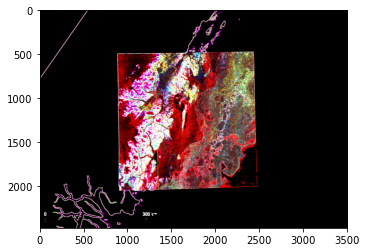

In [142]:
plt.figure()
plt.imshow(10*stdpicsave.astype(int))

The pink junk on the left will have been clipped out by the time the data is cleaned up, but anyway I would say it looks like it could be pretty useful! The different terrains do seem to stand out.

Next I'll split into training, testing, and validation sets. This is in addition to the testing and training observations I already set aside.

In [42]:
# resample the training observations' data to rebalance the classes
training_reduction = 0.1
nsamp = int(training_reduction*(target_train_all.target.value_counts().sort_values().iloc[1]))
dataresampledmat = np.zeros((nsamp, len(cleandata_train_all.columns), len(target_train_all.target.unique())))
targetresampledmat = np.zeros((nsamp, len(target_train_all.columns), len(target_train_all.target.unique())))
for targ in target_train_all.target.unique():
    dataresampledmat[:,:,int(targ)], targetresampledmat[:,:,int(targ)] = resample(cleandata_train_all.loc[target_train_all.target == targ,:],target_train_all.loc[target_train_all.target == targ,:],n_samples=nsamp)
data_resampled = pd.DataFrame(np.hstack(dataresampledmat.transpose()).transpose(), columns=['y', 'x', 'obs', 'red', 'green', 'blue', 'meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB'])
target_resampled = pd.DataFrame(np.hstack(targetresampledmat.transpose()).transpose(), columns=['y', 'x', 'obs', 'target'])

# resample the test observation's data to rebalance the classes
test_reduction = 0.1
nsamp = int(test_reduction*(target_test_all.target.value_counts().sort_values().iloc[1]))
dataresampledmat = np.zeros((nsamp, len(cleandata_test_all.columns), len(target_test_all.target.unique())))
targetresampledmat = np.zeros((nsamp, len(target_test_all.columns), len(target_test_all.target.unique())))
for targ in target_test_all.target.unique():
    dataresampledmat[:,:,int(targ)], targetresampledmat[:,:,int(targ)] = resample(cleandata_test_all.loc[target_test_all.target == targ,:],target_test_all.loc[target_test_all.target == targ,:],n_samples=nsamp)
test_data_resampled = pd.DataFrame(np.hstack(dataresampledmat.transpose()).transpose(), columns=['y', 'x', 'obs', 'red', 'green', 'blue', 'meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB'])
test_target_resampled = pd.DataFrame(np.hstack(targetresampledmat.transpose()).transpose(), columns=['y', 'x', 'obs', 'target'])

# do not rebalance the validation observation

In [43]:
data_resampled.head()

,y,x,obs,red,green,blue,meanR,meanG,meanB,stdR,stdG,stdB
0,458.0,1954.0,2.0,57.0,10.0,20.0,64.520000,10.000000,18.040000,5.131238,0.000000,1.482700
1,1259.0,920.0,8.0,161.0,6.0,6.0,193.304348,5.869565,4.347826,33.530563,1.328757,1.784199
2,1209.0,1152.0,9.0,110.0,159.0,255.0,106.920000,149.720000,254.440000,5.168520,8.548778,2.080000
3,1261.0,1292.0,5.0,110.0,73.0,87.0,120.600000,75.360000,89.000000,7.868926,2.978322,5.973274
4,1080.0,1050.0,8.0,250.0,4.0,3.0,252.120000,4.000000,2.600000,3.191489,0.000000,0.489898


In [44]:
target_resampled.head()

,y,x,obs,target
0,458.0,1954.0,2.0,0.0
1,1259.0,920.0,8.0,0.0
2,1209.0,1152.0,9.0,0.0
3,1261.0,1292.0,5.0,0.0
4,1080.0,1050.0,8.0,0.0


In [45]:
target_resampled.target.value_counts()

0.0    13916
4.0    13916
3.0    13916
1.0    13916
7.0    13916
2.0    13916
5.0    13916
6.0    13916
Name: target, dtype: int64

In [46]:
x_train_all, x_validate, y_train_all, y_validate = model_selection.train_test_split(data_resampled.loc[:,'red':'stdB'], target_resampled.target, test_size=0.1)
# now split the training data further into training and testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train_all, y_train_all, test_size=0.2)
# now split the training data further for plotting and use when the fitting runs slowly
x_train_small, x_test_small, y_train_small, y_test_small = model_selection.train_test_split(x_train_all, y_train_all, test_size=0.02, train_size=0.02)

In [47]:
y_train_small.value_counts()

0.0    284
2.0    258
4.0    257
5.0    255
7.0    246
6.0    239
3.0    235
1.0    229
Name: target, dtype: int64

Next I'll examine the data using seaborn's pairplot function, to gain an insight on how well the classes are separated. I'll just plot a few of the classes.

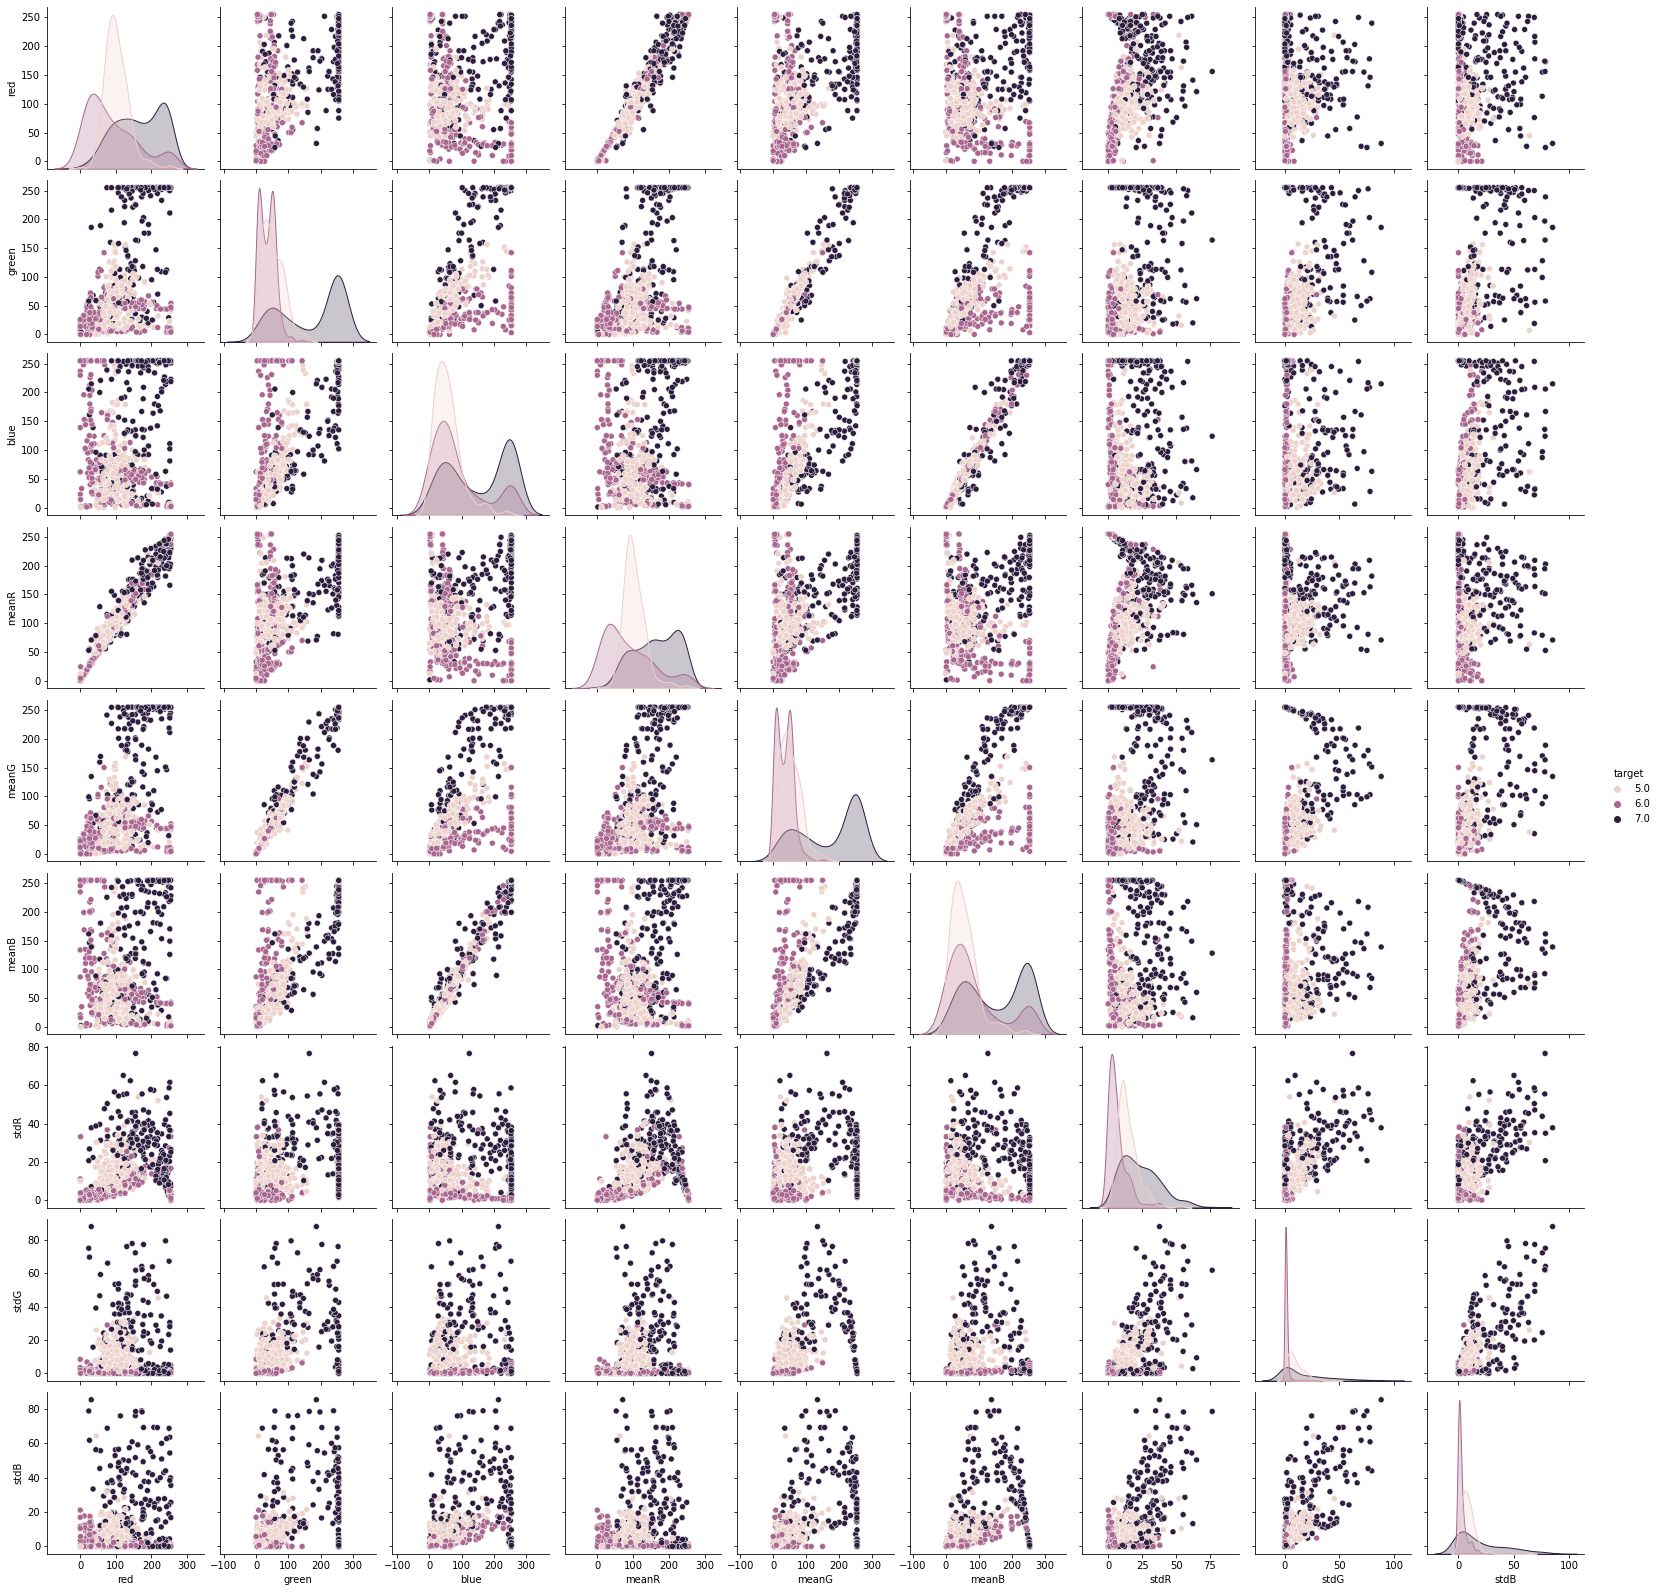

In [48]:
forpariplot = x_train_small.copy()
forpariplot['target']=y_train_small
sns.pairplot(forpariplot.loc[np.isin(forpariplot['target'],(5,6,7))], hue="target")

Okay let's try a different simple approach, an SVM. I'll allow it to use quadratic functions in the features though. It's best to fit an SVM on the smaller set of training data, or it will run forever.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=1, loss="hinge",max_iter=10000,tol=0.01))
    ])

polynomial_svm_clf.fit(x_train_small, y_train_small)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=1, loss='hinge', max_iter=10000, tol=0.01))])

In [50]:
y_pred = polynomial_svm_clf.predict(x_test)

In [51]:
score = accuracy_score(y_test, y_pred)
print(score)

0.46040221567942513


Text(0.5, 15.0, 'predicted label')

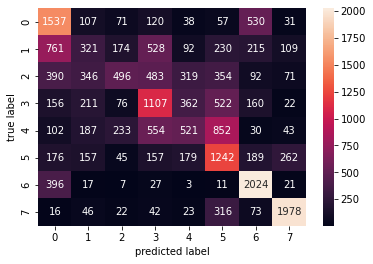

In [52]:
plt.figure()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Not great, but it does okay at discriminating ice from open water from land. Let's test it on the separate test observation:

In [53]:
# try it on the test observations
y_pred = polynomial_svm_clf.predict(test_data_resampled.loc[:,'red':'stdB'])
score = accuracy_score(test_target_resampled.target, y_pred)
print(score)

0.3857484076433121


So the model performs worse on the test observation. It must be overfitting systematics in the data, which are not generalizing to other observations. Let's see if a random forest can do better.

In [54]:
RFclf = RandomForestClassifier(max_depth=10,n_estimators=500)
modelRF = RFclf.fit(x_train,y_train)
y_pred = modelRF.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.5924946354608513


Text(0.5, 15.0, 'predicted label')

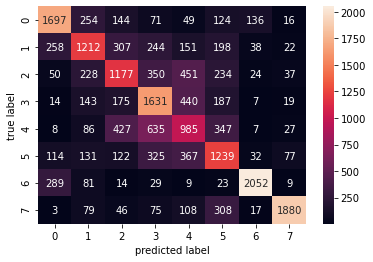

In [55]:
plt.figure()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

So the random forest does a fair bit better on the test set taken from the same observations as the training data. Let's look at which features the model chose as being more important in making its decision.

In [56]:
#print importance of the features
for name, score in zip(list(x_train.columns), RFclf.feature_importances_):
    print(name,': ', score)

red :  0.03741098223892236
green :  0.12252010791223439
blue :  0.07142884797426274
meanR :  0.08641139680586471
meanG :  0.19469806312037094
meanB :  0.12435493917666877
stdR :  0.12258657683404212
stdG :  0.16283020833461775
stdB :  0.07775887760301624


I was expecting the standard deviations to be more important, and but it seems like they are not much less important than the mean of the surrounding pixels. Perhaps this is an indication of the model's overfitting of the systematics of the data images.

Let's look at how well it does on the test observation.

In [57]:
y_pred = modelRF.predict(test_data_resampled.loc[:,'red':'stdB'])
score = accuracy_score(test_target_resampled.target, y_pred)
print(score)

0.3769108280254777


Text(0.5, 15.0, 'predicted label')

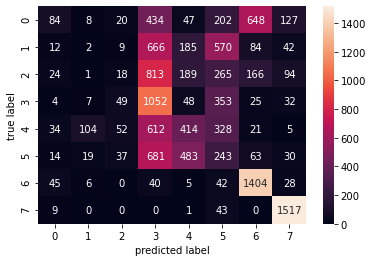

In [58]:
plt.figure()
mat = confusion_matrix(test_target_resampled.target, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Still getting quite confused. Maybe a neural net will do better, though if the systematics of the data are the problem, it's likely that no model will do that much better.

In [59]:
modelNN = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu",input_shape=(9,)),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(8, activation="softmax")
])
modelNN.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.002, momentum=0.8, nesterov=True),
              metrics=["accuracy"])

In [60]:
modelNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 808       
Total params: 42,208
Trainable params: 42,208
Non-trainable params: 0
____________________________________________________

In [61]:
history = modelNN.fit(x_train, y_train, epochs=20, validation_data=(x_test_small, y_test_small))

Epoch 1/20
2505/2505 [==============================] - 3s 1ms/step - loss: 1.3486 - accuracy: 0.4911 - val_loss: 1.1579 - val_accuracy: 0.5484
Epoch 2/20
2505/2505 [==============================] - 4s 1ms/step - loss: 1.1733 - accuracy: 0.5495 - val_loss: 1.1192 - val_accuracy: 0.5749
Epoch 3/20
2505/2505 [==============================] - 3s 1ms/step - loss: 1.1203 - accuracy: 0.5694 - val_loss: 1.1750 - val_accuracy: 0.5444
Epoch 4/20
2505/2505 [==============================] - 3s 1ms/step - loss: 1.0885 - accuracy: 0.5795 - val_loss: 1.0918 - val_accuracy: 0.5788
Epoch 5/20
2505/2505 [==============================] - 3s 1ms/step - loss: 1.0618 - accuracy: 0.5883 - val_loss: 1.0963 - val_accuracy: 0.5729
Epoch 6/20
2505/2505 [==============================] - 3s 1ms/step - loss: 1.0468 - accuracy: 0.5941 - val_loss: 1.0671 - val_accuracy: 0.5813
Epoch 7/20
2505/2505 [==============================] - 3s 1ms/step - loss: 1.0328 - accuracy: 0.5997 - val_loss: 1.0096 - val_accuracy:

In [62]:
#test the NN on the full test subset
y_pred = modelNN.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
score = accuracy_score(y_test, y_pred)
print(score)

0.624681870352812


In [63]:
#test the NN on the test observation
y_pred = modelNN.predict(test_data_resampled.loc[:,'red':'stdB'])
y_pred = np.argmax(y_pred,axis=1)
score = accuracy_score(test_target_resampled.target, y_pred)
print(score)

0.37452229299363055


Text(0.5, 15.0, 'predicted label')

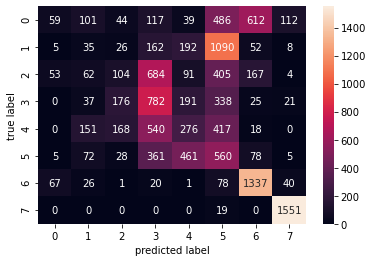

In [64]:
plt.figure()
mat = confusion_matrix(test_target_resampled.target, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Again, the model is getting pretty confused. We can take a peak at the test observation to see if there is anything weird about it.

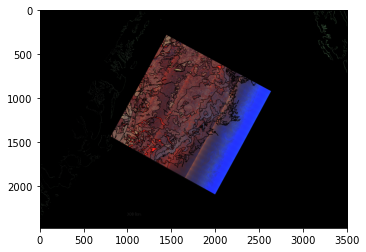

In [65]:
#show the data for the test observation(s)
newpic = np.zeros(rgb[1].shape)
data4plot=cleandata_test_all.loc[cleandata_test_all.obs == testingN[0]]
newpic[data4plot.y.astype(int),data4plot.x.astype(int),0] = data4plot.red
newpic[data4plot.y.astype(int),data4plot.x.astype(int),1] = data4plot.green
newpic[data4plot.y.astype(int),data4plot.x.astype(int),2] = data4plot.blue
plt.figure()
plt.imshow(newpic.astype(int))

Now let's step back and try to figure out how many components I should be able to expect to successfully capture. I'll ignore the labels and use a couple of unsupervised learning techniques to try to find the optimal number of classes.

First scale the input data for use in KMeans and Gaussian Mixture Models

In [66]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

Next fit the data with a KMeans model using different numbers of clusters and calculate the inertia of the fits

If we see an elbow in the plot, that is likely the optimal number of clusers

Starting 0
Starting 1
Starting 2
Starting 3
Starting 4
Starting 5
Starting 6
Starting 7


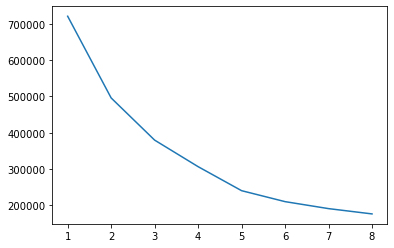

In [67]:
from sklearn.cluster import KMeans
intertias = np.zeros(8)
for i in range(0,8):
    print('Starting '+str(i))
    clf = KMeans(n_clusters=i+1)
    model = clf.fit(x_train_scaled)
    intertias[i] = model.inertia_
plt.figure()
plt.plot(np.arange(8)+1,intertias)

There's no obvious elbow, so let's try calculating the silhouette score for the different numbers of clusters

Starting 1
Starting 2
Starting 3
Starting 4
Starting 5
Starting 6
Starting 7


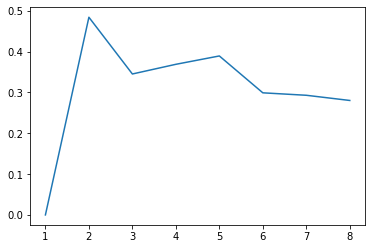

In [68]:
from sklearn.metrics import silhouette_score
scores = np.zeros(8)
for i in range(1,8):
    print('Starting '+str(i))
    clf = KMeans(n_clusters=i+1)
    model = clf.fit(x_train_scaled)
    y_pred = model.predict(x_test_scaled)
    scores[i] = silhouette_score(x_test_scaled,y_pred)
plt.figure()
plt.plot(np.arange(8)+1,scores)

It indicates we should only really expect two clusters from the data. Let's see what it identifies as the clusters by plotting them on the map.

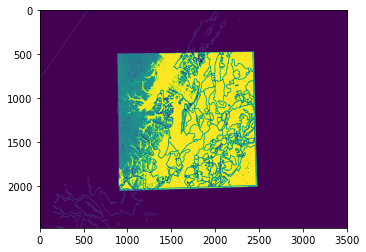

In [69]:
#show distribution of the clusters
clfKM = KMeans(n_clusters=2)
model = clfKM.fit(x_train_scaled)
data4plot = cleandata_train_all.loc[cleandata_train_all.obs == trainingN[3]]
y_pred = model.predict(scaler.fit_transform(data4plot.loc[:,'red':'stdB']))
newpic = np.zeros(rgb[1].shape[:2])-1
newpic[data4plot.y.astype(int),data4plot.x.astype(int)] = y_pred
plt.figure()
plt.imshow(newpic.astype(int))

So we should definitely be able to tell land from non-land. I think I would hope for at least one more category: ice or open water. Let's see if a gaussian mixture model can tell us anything more by calculating the BIC and AIC scores for different numbers of clusters.

Starting 0
Starting 1
Starting 2
Starting 3
Starting 4
Starting 5
Starting 6
Starting 7


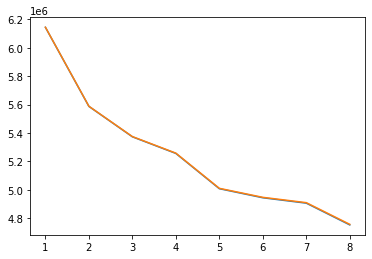

In [70]:
from sklearn.mixture import GaussianMixture
bics = np.zeros(8)
aics = np.zeros(8)
for i in range(0,8):
    print('Starting '+str(i))
    clf = GaussianMixture(n_components=i+1)
    model = clf.fit(x_train)
    bics[i] = model.bic(x_train)
    aics[i] = model.aic(x_train)
plt.figure()
plt.plot(np.arange(8)+1,aics)
plt.plot(np.arange(8)+1,bics)

It seems to favor adding more and more clusters, but as we saw above the models aren't really good at distinguishing that many classes.

To try something else, now I'll recast the data so that the models are fed a small image (13x13 pixels) around each pixel. I'll take the target to be the mode of the terrain types within the image. This way I'll be able to try a convolutional neural net, which can be quite good at image recognition. 

In [71]:
#reconstruct the pictures to use in a CNN, then chop them into 13X13 squares for passing to the CNN 
subimagesize = 13
step = 13
nx = int(rgb[1].shape[1]/step)
ny = int(rgb[1].shape[0]/step)
subimagesTrain = np.zeros((nx*ny*len(trainingN), subimagesize, subimagesize, 3))
subimgtargetTrain = np.zeros(nx*ny*len(trainingN)) - 100
subimagesTest = np.zeros((nx*ny*len(testingN), subimagesize, subimagesize, 3))
subimgtargetTest = np.zeros(nx*ny*len(testingN)) - 100
subimagesVal = np.zeros((nx*ny*len(valN), subimagesize, subimagesize, 3))
subimgtargetVal = np.zeros(nx*ny*len(valN)) - 100
train_i = 0
test_i = 0
val_i = 0
for j in obs:
    print('Starting obs ' + str(j))
    if j in trainingN:
        data = cleandata_train_all.copy()
        targs = target_train_all.copy()
        train_i += 1
    elif j in testingN:
        data = cleandata_test_all.copy()
        targs = target_test_all.copy()
        test_i += 1
    elif j in valN:
        data = cleandata_val_all.copy()
        targs = target_val_all.copy()
        val_i += 1
    
    # reconstruct the images from the cleaned data
    newpic = np.zeros(rgb[j].shape)
    # set the target to -100 for pixels without good data
    newtargpic = np.zeros(rgb[j].shape[:2]) - 100
    data4plot = data.loc[data.obs == j]
    targs4plot=targs.loc[targs.obs == j]
    newpic[data4plot.y.astype(int),data4plot.x.astype(int),0] = data4plot.red
    newpic[data4plot.y.astype(int),data4plot.x.astype(int),1] = data4plot.green
    newpic[data4plot.y.astype(int),data4plot.x.astype(int),2] = data4plot.blue
    newtargpic[targs4plot.y.astype(int),targs4plot.x.astype(int)] = targs4plot.target
    
    # now chop the images into squares and stack them in the appropriate array
    startx = 0
    endx = startx + subimagesize
    for i in range(0,nx):
        starty = 0
        endy = starty + subimagesize
        for k in range(0,ny):
            modetarget = int(stats.mode(newtargpic[starty:endy,startx:endx],axis=None)[0])
            if np.all(newpic[starty:endy,startx:endx,:] == 0) | (modetarget == -100):
                starty = starty + step
                endy = starty + subimagesize
                continue  #skip bad data
            if j in trainingN:
                subimagesTrain[(train_i-1)*nx*ny + ny*i + k,:,:,:]=newpic[starty:endy,startx:endx,:]
                subimgtargetTrain[(train_i-1)*nx*ny + ny*i + k]=modetarget
            elif j in testingN:
                subimagesTest[(test_i-1)*nx*ny + ny*i + k,:,:,:]=newpic[starty:endy,startx:endx,:]
                subimgtargetTest[(test_i-1)*nx*ny + ny*i + k]=modetarget
            elif j in valN:
                subimagesVal[(val_i-1)*nx*ny + ny*i + k,:,:,:]=newpic[starty:endy,startx:endx,:]
                subimgtargetVal[(val_i-1)*nx*ny + ny*i + k]=modetarget
            starty=starty + step
            endy=starty + subimagesize
        startx = startx + step
        endx = startx + subimagesize
        
# Exclude images where the target is -100, indicating insufficient good data within the image
subimagesTrain = subimagesTrain[subimgtargetTrain != -100,:,:,:]
subimgtargetTrain = subimgtargetTrain[subimgtargetTrain != -100]      
subimagesTest = subimagesTest[subimgtargetTest != -100,:,:,:]
subimgtargetTest = subimgtargetTest[subimgtargetTest != -100]  
subimagesVal = subimagesVal[subimgtargetVal != -100,:,:,:]
subimgtargetVal = subimgtargetVal[subimgtargetVal != -100]  
print('Done!')

Starting obs 1
Starting obs 2
Starting obs 5
Starting obs 6
Starting obs 8
Starting obs 9
Starting obs 10
Starting obs 4
Starting obs 12
Done!


In [72]:
# Check the output
print(subimagesTrain.shape)
print(subimgtargetTrain.shape)
print(subimagesTest.shape)
print(subimgtargetTest.shape)
print(subimagesVal.shape)
print(subimgtargetVal.shape)

(95453, 13, 13, 3)
(95453,)
(9550, 13, 13, 3)
(9550,)
(13267, 13, 13, 3)
(13267,)


In [73]:
pd.Series(subimgtargetTrain).value_counts()

6.0    59954
5.0    21286
7.0     5393
0.0     3497
4.0     2329
1.0     1392
2.0      873
3.0      729
dtype: int64

In [74]:
pd.Series(subimgtargetTest).value_counts()

5.0    5553
6.0    3068
4.0     497
2.0     170
3.0     100
1.0      92
0.0      70
dtype: int64

In [75]:
pd.Series(subimgtargetVal).value_counts()

5.0    7903
6.0    4153
4.0     492
1.0     328
7.0     261
3.0     130
dtype: int64

Again, resample the training and test data to rebalance the classes

In [76]:
# resample the training observations' data to rebalance the classes
training_reduction = 1
subimgtargetTrainDF = pd.Series(subimgtargetTrain)
nsamp = int(training_reduction*(subimgtargetTrainDF.value_counts().sort_values().iloc[1]))
dataresampledmat = np.zeros((nsamp, subimagesize, subimagesize, 3, len(subimgtargetTrainDF.unique())))
targetresampledmat = np.zeros((nsamp, len(subimgtargetTrainDF.unique())))
for targ in subimgtargetTrainDF.unique():
    dataresampledmat[:,:,:,:,int(targ)], targetresampledmat[:,int(targ)] = resample(subimagesTrain[subimgtargetTrain == targ,:,:,:],subimgtargetTrain[subimgtargetTrain == targ],n_samples=nsamp)
data_img_resampled = np.vstack(np.moveaxis(dataresampledmat, -1, 0))
targ_img_resampled = np.hstack(targetresampledmat.transpose())


# resample the test observation's data to rebalance the classes
testing_reduction = 1
subimgtargetTestDF = pd.Series(subimgtargetTest)
nsamp=int(testing_reduction*(subimgtargetTestDF.value_counts().sort_values().iloc[1]))
dataresampledmat = np.zeros((nsamp, subimagesize, subimagesize, 3, len(subimgtargetTestDF.unique())))
targetresampledmat = np.zeros((nsamp,len(subimgtargetTestDF.unique())))
for targ in subimgtargetTestDF.unique():
    dataresampledmat[:,:,:,:,int(targ)], targetresampledmat[:,int(targ)] = resample(subimagesTest[subimgtargetTest == targ,:,:,:],subimgtargetTest[subimgtargetTest == targ],n_samples=nsamp)
data_test_img_resampled = np.vstack(np.moveaxis(dataresampledmat, -1, 0))
targ_test_img_resampled = np.hstack(targetresampledmat.transpose())


# do not rebalance the validation observation

In [77]:
print(data_img_resampled.shape)
pd.Series(targ_img_resampled).value_counts()

(6984, 13, 13, 3)


0.0    873
6.0    873
5.0    873
1.0    873
4.0    873
2.0    873
3.0    873
7.0    873
dtype: int64

And split the trainging observations' data into training, testing, and validation

In [80]:
x_train_all, x_validate, y_train_all, y_validate = model_selection.train_test_split(data_img_resampled, targ_img_resampled, test_size=0.1)
# now split the training data further into training and testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train_all, y_train_all, test_size=0.2)
# now split the training data further for plotting and use when the fitting runs slowly
#x_train_small, x_test_small, y_train_small, y_test_small = model_selection.train_test_split(x_train_all, y_train_all, test_size=0.02,train_size=0.02)

Let's look at one of the images.

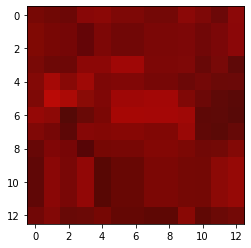

In [81]:
plt.figure()
plt.imshow(x_train[1672,:,:,:].astype(int))

The overall color probably has some meaning, but so does the variation in color and the small scale patters. Maybe the CNN will perform better, but maybe it will not be able to ignore the systematics, like in the previous cases.

In [106]:
modelCNN = keras.models.Sequential([
    keras.layers.Conv2D(20, 7, activation="selu", padding="same",
                        input_shape=x_train[0,:,:,:].shape),
    keras.layers.Conv2D(100, 5, activation="selu", padding="same"),
    keras.layers.Conv2D(100, 5, activation="selu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(120, 3, activation="selu", padding="same"),
    keras.layers.Conv2D(120, 3, activation="selu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(40, activation="selu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax")
])

In [107]:
# take a look at the model parameters and structure
modelCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 13, 13, 20)        2960      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 100)       50100     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 100)       250100    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 100)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 120)         108120    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 120)         129720    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 120)        

In [108]:
modelCNN.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.02),
              metrics=["accuracy"])

In [109]:
# train the model
history = modelCNN.fit(x_train/ 255.0, y_train, epochs=25,
                     validation_data=(x_test/255., y_test))

Epoch 1/25
158/158 [==============================] - 27s 173ms/step - loss: 2.7927 - accuracy: 0.1961 - val_loss: 2.2489 - val_accuracy: 0.1519
Epoch 2/25
158/158 [==============================] - 26s 167ms/step - loss: 1.7943 - accuracy: 0.2969 - val_loss: 1.6905 - val_accuracy: 0.3262
Epoch 3/25
158/158 [==============================] - 28s 174ms/step - loss: 1.6747 - accuracy: 0.3528 - val_loss: 2.0281 - val_accuracy: 0.2928
Epoch 4/25
158/158 [==============================] - 27s 173ms/step - loss: 1.6264 - accuracy: 0.3703 - val_loss: 1.5331 - val_accuracy: 0.3866
Epoch 5/25
158/158 [==============================] - 28s 177ms/step - loss: 1.5831 - accuracy: 0.3904 - val_loss: 1.8823 - val_accuracy: 0.3055
Epoch 6/25
158/158 [==============================] - 28s 177ms/step - loss: 1.5446 - accuracy: 0.4053 - val_loss: 1.5085 - val_accuracy: 0.4248
Epoch 7/25
158/158 [==============================] - 28s 174ms/step - loss: 1.4957 - accuracy: 0.4189 - val_loss: 1.4593 - val_ac

In [110]:
modelCNN.evaluate(x_test/255., y_test)

40/40 [==============================] - 2s 42ms/step - loss: 1.5802 - accuracy: 0.5760


[1.5802156925201416, 0.5759745240211487]

In [111]:
#test the CNN on the test observation
y_pred = modelCNN.predict(data_test_img_resampled/255.)
y_pred = np.argmax(y_pred,axis=1)
score = accuracy_score(targ_test_img_resampled, y_pred)
print(score)

0.2639751552795031


Text(0.5, 15.0, 'predicted label')

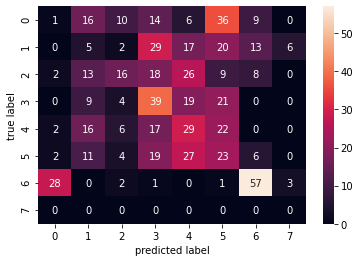

In [112]:
plt.figure()
mat = confusion_matrix(targ_test_img_resampled, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Okay it looks like the CNN doesn't really do much better than the simpler models of the previous section. Unfortunately, a better model might require more data or an assesment of how to remove systematic features. Let's just try one more thing, another random forest using the small images.

In [113]:
# reshape the data to be used by the random forest
x4RF = np.reshape(x_train,(len(x_train),-1))
x4RFtest = np.reshape(x_test,(len(x_test),-1))

In [114]:
RFclf = RandomForestClassifier(max_depth=15,n_estimators=500,verbose=0)
modelRF = RFclf.fit(x4RF,y_train)
y_pred = modelRF.predict(x4RFtest)
score = accuracy_score(y_test, y_pred)
print(score)

0.6746221161495625


In [115]:
x4RFtest2 = np.reshape(data_test_img_resampled,(len(data_test_img_resampled),-1))
y_pred = modelRF.predict(x4RFtest2)
score = accuracy_score(targ_test_img_resampled, y_pred)
print(score)

0.2826086956521739


Let's try something simpler: just fitting to the three categories: land, ice, and open water

In [116]:
y_train_reduced = y_train.copy()
y_train_reduced[(y_train_reduced < 5)] = 5
y_test_reduced = y_test.copy()
y_test_reduced[(y_test_reduced < 5)] = 5
y_test_reduced2 = targ_test_img_resampled.copy()
y_test_reduced2[(y_test_reduced2 < 5)] = 5
y_val_reduced = y_validate.copy()
y_val_reduced[(y_val_reduced<5)] = 5

In [117]:
history = modelCNN.fit(x_train/ 255.0, y_train_reduced, epochs=4,
                     validation_data=(x_test/255., y_test_reduced))

Epoch 1/4
158/158 [==============================] - 26s 166ms/step - loss: 0.4447 - accuracy: 0.8725 - val_loss: 0.4417 - val_accuracy: 0.8783
Epoch 2/4
158/158 [==============================] - 28s 177ms/step - loss: 0.2363 - accuracy: 0.9173 - val_loss: 0.5006 - val_accuracy: 0.8417
Epoch 3/4
158/158 [==============================] - 28s 175ms/step - loss: 0.1822 - accuracy: 0.9383 - val_loss: 0.2987 - val_accuracy: 0.9189
Epoch 4/4
158/158 [==============================] - 28s 175ms/step - loss: 0.1313 - accuracy: 0.9562 - val_loss: 0.3003 - val_accuracy: 0.9196


In [118]:
#test the CNN on the test observation
y_pred = modelCNN.predict(data_test_img_resampled/255.)
y_pred = np.argmax(y_pred,axis=1)
score = accuracy_score(y_test_reduced2, y_pred)
print(score)

0.8913043478260869


Text(0.5, 15.0, 'predicted label')

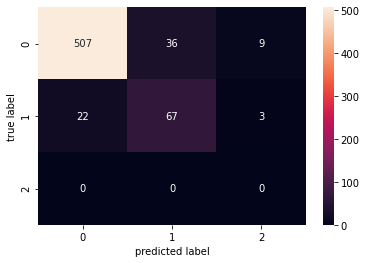

In [119]:
plt.figure()
mat = confusion_matrix(y_test_reduced2, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

In [120]:
RFclf = RandomForestClassifier(max_depth=15,n_estimators=500,verbose=0)
modelRF = RFclf.fit(x4RF,y_train_reduced)
y_pred = modelRF.predict(x4RFtest)
score = accuracy_score(y_test_reduced, y_pred)
print(score)

0.9132856006364359


In [121]:
# reshape the test data to be used by the random forest
x4RFtest2 = np.reshape(data_test_img_resampled,(len(data_test_img_resampled),-1))
y_pred = modelRF.predict(x4RFtest2)
score = accuracy_score(y_test_reduced2, y_pred)
print(score)

0.9549689440993789


Text(0.5, 15.0, 'predicted label')

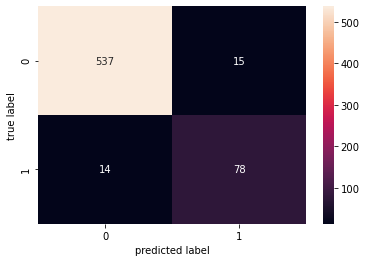

In [122]:
plt.figure()
mat = confusion_matrix(y_test_reduced2, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

Obviously the models are doing much better. Let's select this final random forest as our final model, and evaluate it on the validation data

In [138]:
# reshape the validation data to be used by the random forest
x4RFval = np.reshape(x_validate,(len(x_validate),-1))
y_pred = modelRF.predict(x4RFval)
score = accuracy_score(y_val_reduced, y_pred)
print(score)

0.9170243204577968


In [124]:
subimagesVal.shape

(13267, 13, 13, 3)

In [125]:
y_val_reduced2 = subimgtargetVal.copy()
y_val_reduced2[(y_val_reduced2 < 5)] = 5

In [126]:
#test the RF on the val observation
x4RFval2 = np.reshape(subimagesVal,(len(subimagesVal),-1))
y_pred = modelRF.predict(x4RFval2)
score = accuracy_score(y_val_reduced2, y_pred)
print(score)

0.9507047561619055


Text(0.5, 15.0, 'predicted label')

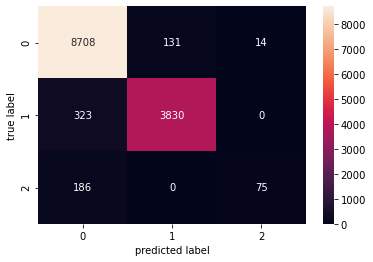

In [127]:
plt.figure()
mat = confusion_matrix(y_val_reduced2, y_pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=True) 
plt.ylabel('true label')
plt.xlabel('predicted label')

So the model is still missclassifying the land. Perhaps the model using the mean and standard deviation would have performed better on this data. In hindsight, it was a problem that the test observation did not have any land images when processed this way. 

Maybe peaking at the validation data will give some insight:

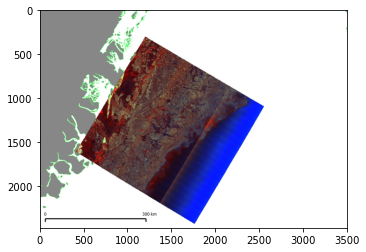

In [128]:
plt.figure()
plt.imshow(rgb[12])

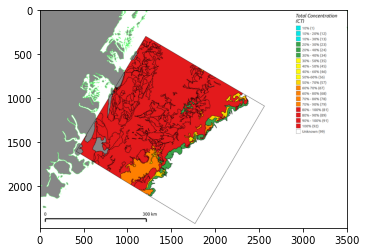

In [129]:
plt.figure()
plt.imshow(conc[12])

It seems the land comes in two varieties in this data: some of it is dark red in the data while some of it is quite bright. Overall, this project has demonstrated that more data will be necessary to teach the models how to ignore systematic problems. Otherwise, better preprocessing to remove systematics could help. 